Step1: define the problem
1. The business objective: identify factors and 2. build a model to predict if order will be fulfilled on time or delay.
2. The problem is supurvised learning, and a classfication problem
3. performance evaluation: ROC/AUC,recall/precision

In [1]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import data
df=pd.read_csv('Consolidated data.csv')
print('Dataframe dimensions:', df.shape)


Dataframe dimensions: (12065, 58)


Step2: Data Cleaning and manipulation before data exploration

In [3]:
#subset only delivered and know labels' data
df_d=df[(df['SHP_PACK_DLVRY_STS_KEY']==6)&(df['SPDPD_KEY']!=1)&(df['SPDPD_KEY']!=10)]
df_d=df_d.dropna(subset=['SPDPD_KEY'])
df_d['ontime_ornot']=df_d['SPDPD_KEY']
df_d['ontime_ornot']=df_d['ontime_ornot'].replace([2,4],1).replace([3,5,6,7,8,9],0)


In [4]:
#ratio of delay:
1-sum(df_d['ontime_ornot'])/len(df_d)

0.07815777473780205

In [6]:
#drop clearly not relevant columns
df_d=df_d.drop(['CREATED_TS','CREATED_USER','UPDATED_TS','UPDATED_USER','FRAUD_CHECK_REQD_IND','CORP_ORDER_IND','CONSUMER_CNTCT_ID','TENANT_ASSOC_ID'],axis=1)


In [7]:
#unify null
df_d=df_d.replace('?',np.nan)
df_d=df_d.replace('NULL',np.nan)


In [8]:
#clean time stamp
for i in (5,6,7,9,10,12,15,16,17):
    for j in range(len(df_d)):
        if type(df_d.iloc[j,i]) is str:
            df_d.iloc[j,i]=df_d.iloc[j,i][:-13]


In [9]:
#clean SHIPPED_PACKAGE_PRICE_AMT
df_d['SHIPPED_PACKAGE_PRICE_AMT']=df_d['SHIPPED_PACKAGE_PRICE_AMT'].str.replace(",","").astype(float)
df_d['SHIPPED_PACKAGE_PRICE_AMT']=df_d['SHIPPED_PACKAGE_PRICE_AMT'].astype(float)

In [10]:
#change time stamp date type

for i in ('ORDER_TS','EXPECTED_DELIVERY_TS','LEAST_DELIVERY_TS','DETERMINED_DELIVERY_TS','EXPECTED_SHIPMENT_TS','CARRIER_EXPECTED_DELIVERY_TS','CARGO_DEPARTED_TS','INITIAL_DLVR_ATMPT_TS','FINAL_DELIVERY_ATMPT_TS','ACTUAL_DELIVERY_TS','ORDER_REL_TS','ORDER_PLACED_TS'):
    df_d[i]=pd.to_datetime(df_d[i])
    


In [11]:
#change index
df_d.index=range(len(df_d))


In [12]:
#create test data: stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit
sp = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in sp.split(df_d, df_d['ontime_ornot']):
        df_train = df_d.loc[train_index]
        df_test = df_d.loc[test_index]
print(df_train.shape)
print(df_test.shape)
combine=[df_train,df_test]


(8772, 51)
(2193, 51)


Step3: Data exploration
(more on the report)

DSTRBTR_KEY
1    0.094772
2    0.034188
3    0.071545
4    0.069767
Name: ontime_ornot, dtype: float64


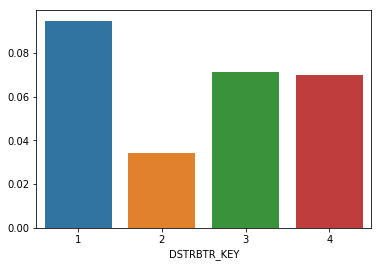

In [13]:
# explore analysis
#1. distributor feature:
a=1-df_train['ontime_ornot'].groupby(df_train['DSTRBTR_KEY']).apply(np.mean)
print(a)
sns.barplot(a.index,a.values)
#conclusion: distributor is a factor

order_month
1.0     0.166667
1.5     0.036304
2.0     0.073801
2.5     0.106897
3.0     0.114667
3.5     0.090909
4.0     0.086957
4.5     0.037415
5.0     0.038462
5.5     0.071611
6.0     0.048980
6.5     0.072727
7.0     0.052632
7.5     0.075975
8.0     0.084592
8.5     0.043590
9.0     0.123393
9.5     0.057751
10.0    0.037572
10.5    0.106017
11.0    0.066265
11.5    0.113483
12.0    0.051667
12.5    0.000000
Name: ontime_ornot, dtype: float64

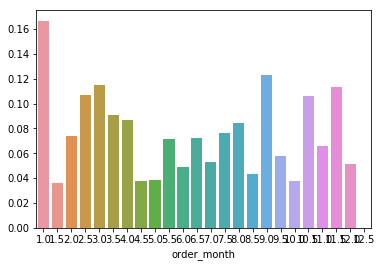

In [14]:
#2. feature engineering: order month (half month)
combine=[df_train,df_test]
for data in combine:
    data['order_month']=''
    for j in range(len(data)):
        if data.iloc[j,5].day in range(15):
            a=0
        else:
            a=0.5
        data.iloc[j,51]=data.iloc[j,5].month+a
a=1-df_train['ontime_ornot'].groupby(df_train['order_month']).apply(np.mean)
sns.barplot(a.index,a.values)
a
#conclusion: seasonality is an important feature

In [15]:
#3. SHIPPED_PACKAGE_PRICE_AMT : more on tableau
df_train[['SHIPPED_PACKAGE_PRICE_AMT','TOT_AMT']].groupby(df_train['ontime_ornot']).apply(np.mean)




,SHIPPED_PACKAGE_PRICE_AMT,TOT_AMT
ontime_ornot,,
0,36.350598,82.881412
1,30.382483,88.327062


In [16]:
#4. feature engineering use timestamp-----expected delivery time
df_train['expected delivery time']=df_train['EXPECTED_DELIVERY_TS']-df_train['ORDER_TS']
df_test['expected delivery time']=df_test['EXPECTED_DELIVERY_TS']-df_test['ORDER_TS']
print("Expected delivery time for on time")
print(df_train[df_train['ontime_ornot']==1]['expected delivery time'].describe())
print('------------')
print("Expected delivery time for delays")
print(df_train[df_train['ontime_ornot']==0]['expected delivery time'].describe())


Expected delivery time for on time
count                      8086
mean     5 days 17:05:53.476131
std      3 days 16:21:17.901670
min             0 days 21:48:06
25%      2 days 18:49:35.750000
50%             4 days 15:18:21
75%      8 days 01:53:15.250000
max            39 days 21:26:48
Name: expected delivery time, dtype: object
------------
Expected delivery time for delays
count                       686
mean     4 days 08:31:47.288629
std      2 days 18:43:33.584231
min             0 days 22:47:52
25%      2 days 07:12:52.250000
50%             3 days 05:24:30
75%      5 days 05:12:17.750000
max            14 days 19:29:35
Name: expected delivery time, dtype: object


In [17]:
#5. states----on tableau
#rename state column

df_train=df_train.rename(columns={'CITY_STATE_INFO_Vcol':'state'})  
df_test=df_test.rename(columns={'CITY_STATE_INFO_Vcol':'state'}) 


In [18]:
#determined-least
df_train['delivery time range']=df_train['DETERMINED_DELIVERY_TS']-df_train['LEAST_DELIVERY_TS']
df_test['delivery time range']=df_test['DETERMINED_DELIVERY_TS']-df_train['LEAST_DELIVERY_TS']
print("Expected delivery range for on time")
print(df_train[df_train['ontime_ornot']==1]['delivery time range'].describe())
print('------------')
print("Expected delivery range for delay")
print(df_train[df_train['ontime_ornot']==0]['delivery time range'].describe())
#analysis: this is an effective factor, but need to check correlation
#correlation between quantitative attributes
df_train[(df_train['delivery time range'].notnull())&(df_train['TOT_AMT'].notnull())][['delivery time range','expected delivery time','ontime_ornot','SHIPPED_PACKAGE_PRICE_AMT','TOT_AMT']].astype(int).corr().sort_values(by='ontime_ornot',ascending=False)


Expected delivery range for on time
count                      8085
mean     1 days 00:28:19.146567
std      2 days 01:52:10.152815
min             0 days 00:00:00
25%             0 days 00:00:00
50%             0 days 00:00:00
75%             0 days 00:00:00
max            15 days 00:00:00
Name: delivery time range, dtype: object
------------
Expected delivery range for delay
count                       686
mean     0 days 09:16:16.093294
std      1 days 08:17:55.925594
min             0 days 00:00:00
25%             0 days 00:00:00
50%             0 days 00:00:00
75%             0 days 00:00:00
max             6 days 00:00:00
Name: delivery time range, dtype: object


,delivery time range,expected delivery time,ontime_ornot,SHIPPED_PACKAGE_PRICE_AMT,TOT_AMT
ontime_ornot,0.082906,0.099334,1.000000,-0.026392,0.012059
expected delivery time,0.726382,1.000000,0.099334,0.084179,-0.001928
delivery time range,1.000000,0.726382,0.082906,-0.015827,-0.001453
TOT_AMT,-0.001453,-0.001928,0.012059,-0.023263,1.000000
SHIPPED_PACKAGE_PRICE_AMT,-0.015827,0.084179,-0.026392,1.000000,-0.023263


Step4: data manipulation after data exploration
    1. one-hot encoding for categorical features
    2. feature scaling for quantitative features
    3. complete null values

In [19]:
#extract factors
df_train_model=df_train[['DSTRBTR_KEY','state','order_month','SHIPPED_PACKAGE_PRICE_AMT','expected delivery time','delivery time range','TOT_AMT','ontime_ornot']]
df_test_model=df_test[['DSTRBTR_KEY','state','order_month','SHIPPED_PACKAGE_PRICE_AMT','expected delivery time','delivery time range','TOT_AMT','ontime_ornot']]

In [20]:
df_train_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8772 entries, 100 to 7050
Data columns (total 8 columns):
DSTRBTR_KEY                  8772 non-null int64
state                        8772 non-null object
order_month                  8772 non-null object
SHIPPED_PACKAGE_PRICE_AMT    8772 non-null float64
expected delivery time       8772 non-null timedelta64[ns]
delivery time range          8771 non-null timedelta64[ns]
TOT_AMT                      8712 non-null float64
ontime_ornot                 8772 non-null int64
dtypes: float64(2), int64(2), object(2), timedelta64[ns](2)
memory usage: 936.8+ KB


In [21]:
#one-hot encoding for distributor, state and month
df_train_model=pd.get_dummies(df_train_model, columns=['DSTRBTR_KEY','order_month','state'])
df_test_model=pd.get_dummies(df_test_model, columns=['DSTRBTR_KEY','order_month','state'])

In [22]:
df_train_model['TOT_AMT']=df_train_model['TOT_AMT'].fillna(df_train_model['TOT_AMT'].median())
df_test_model['TOT_AMT']=df_test_model['TOT_AMT'].fillna(df_test_model['TOT_AMT'].median())

In [23]:
#scalling for SHIPPED_PACKAGE_PRICE_AMT,OT_AMT, and expected delivery time
df_train_model['expected delivery time']=df_train_model['expected delivery time'].astype(int)
df_test_model['expected delivery time']=df_test_model['expected delivery time'].astype(int)
df_train_model['delivery time range']=df_train_model['delivery time range'].astype(int)
df_test_model['delivery time range']=df_test_model['delivery time range'].astype(int)
from sklearn.preprocessing import StandardScaler
df_train_model.iloc[:,0:4]= StandardScaler().fit_transform(df_train_model.iloc[:,0:4])
df_test_model.iloc[:,0:4]= StandardScaler().fit_transform(df_test_model.iloc[:,0:4])


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [24]:
#remove states with too few observations
a=pd.Series(df_train.index).groupby(df_train['state']).agg('count')
print(a[a<10])
df_train_model=df_train_model.drop(['state_AE','state_AK','state_HI','state_PR','state_VI','state_WY'],axis=1)
df_test_model=df_test_model.drop(['state_AK','state_HI','state_VI','state_WY'],axis=1)
#add IA so that train and test data can be same
df_test_model['state_IA']=0
df_test_model['state_DC']=0
df_test_model=df_test_model[list(df_train_model.columns)]




state
AE    9
AK    3
HI    4
PR    1
VI    9
WY    6
dtype: int64


In [111]:
df_train_model=df_train_model.drop('Unnamed: 0',axis=1)
df_test_model=df_test_model.drop('Unnamed: 0',axis=1)

In [25]:
df_train_model.to_csv('df_train_model.csv')
df_test_model.to_csv('df_test_model.csv')

In [26]:
df_train_model=pd.read_csv('df_train_model.csv')
df_test_model=pd.read_csv('df_test_model.csv')

Step 5:  find the best model
1. Models used: Random Forest, Xgboost,KNN, Logistic regression
2. Evalution metrics: I use AUC/ROC because it is animblance classification problem
3. Avoid overfitting techniques: K-fold cross validation, tuning hyperparameters



In [132]:
#split into X and y
X=df_train_model.drop('ontime_ornot',axis=1)
y=df_train_model['ontime_ornot']

In [134]:
#tune randanm forest
#hyperparameter: number of trees, max depth, and max features
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
model = ensemble.RandomForestClassifier()
n_estimators = range(50, 500, 50)
max_depth=range(3,20,1)
max_features=('sqrt','log2')
param_grid = dict(n_estimators=n_estimators,max_features =max_features,max_depth=max_depth)
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.816257 using {'max_depth': 19, 'max_features': 'log2', 'n_estimators': 450}


In [135]:
#tune xgboost
#tune number of trees, max depth
import xgboost as xgb
model = xgb.XGBClassifier()
n_estimators = range(50, 500, 50)
max_depth=range(3,10,1)
param_grid = dict(n_estimators=n_estimators,max_depth=max_depth)
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.806741 using {'max_depth': 9, 'n_estimators': 250}


In [136]:
#tune knn
#tune number of neigbors
from sklearn.neighbors import KNeighborsClassifier
model =KNeighborsClassifier()
n_neighbors = range(5, 20, 1)
param_grid = dict(n_neighbors=n_neighbors)
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.735478 using {'n_neighbors': 6}


In [120]:
#tune logistic regression
#tune l1 or l2 regularization
from sklearn.linear_model import LogisticRegression
model =LogisticRegression()
penalty=('l1','l2')
param_grid = dict(penalty=penalty)
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.676890 using {'penalty': 'l1'}


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [137]:
#based on the cross validation result, the best model is as follow:
model=ensemble.RandomForestClassifier(max_depth=19,max_features='log2',n_estimators=450)


Precision-recall trade off: find the best threshold
1. In this problem, we want to capture the delays as much as possible. False positives are less important than false negatives. Since recall is more important than precision, we use an adjusted F1 score as metric, which gives more weight to recall, to find the best threshold (no accurate meaning, need more business data to have more specific metrics)

In [138]:
#precision recall trade off:
# 
from sklearn.metrics import confusion_matrix

Performance=[]
for thr in np.arange(0.1,0.5,0.05):
    re=[]
    pr=[]
    kf = StratifiedKFold(n_splits=4, random_state=42)
    for train_index, test_index in kf.split(X.values,y.values):
        X_train_folds = X.values[train_index]
        y_train_folds = (y.values[train_index])
        X_test_fold = X.values[test_index]
        y_test_fold = (y.values[test_index])
        model.fit(X_train_folds, y_train_folds)
        y_predict=pd.DataFrame(model.predict_proba(X_test_fold))
        b=y_predict.iloc[:,0]
        y_predict['prediction']=np.where(b>=thr,0,1)
        y_predict=y_predict['prediction'].values
        m=confusion_matrix(y_test_fold,y_predict)
        re.append(m[0,0]/(m[0,0]+m[0,1]))
        pr.append(m[0,0]/(m[0,0]+m[1,0]))
    PR=sum(pr)/len(pr)
    RE=sum(re)/len(re)
    performance=['Random Forest',thr,RE,PR,2/(2/RE+1/PR)]
    Performance.append(performance)
Performance=pd.DataFrame(Performance)
Performance.columns=['model','threshold','recall','precision','metrics_defined']
Performance.sort_values(by='metrics_defined',ascending=False)

#Based on the metric, the best threshold is 0.15


,model,threshold,recall,precision,metrics_defined
1,Random Forest,0.15,0.443169,0.484511,0.304095
0,Random Forest,0.10,0.613746,0.271640,0.288184
2,Random Forest,0.20,0.352756,0.650777,0.277536
3,Random Forest,0.25,0.295883,0.736249,0.246376
4,Random Forest,0.30,0.241959,0.807950,0.210447
5,Random Forest,0.35,0.188018,0.889056,0.170039
6,Random Forest,0.40,0.148664,0.900735,0.137331
7,Random Forest,0.45,0.126810,0.942369,0.118816


In [139]:
#test on test data now

X_test=df_test_model.drop('ontime_ornot',axis=1)
y_test=df_test_model['ontime_ornot']
model.fit(X,y)
y_predict=pd.DataFrame(model.predict_proba(X_test))
b=y_predict.iloc[:,0]
y_predict['prediction']=np.where(b>=0.15,0,1)
m=confusion_matrix(y_test,y_predict['prediction'])
re=m[0,0]/(m[0,0]+m[0,1])
pr=m[0,0]/(m[0,0]+m[1,0])
ac=(m[0,0]+m[1,1])/(m[0,0]+m[1,1]+m[0,1]+m[1,0])

print('test result: accuracy','{:.3%}'.format(ac),'recall','{:.3%}'.format(re),'precision','{:.3%}'.format(pr))




test result: accuracy 91.518% recall 37.427% precision 44.755%
